# Raw compositing 

## Load package

In [9]:
import numpy as np;
import netCDF4 as nc;

from joblib     import Parallel, delayed;

from matplotlib import gridspec;
from matplotlib import pyplot as plt;
from matplotlib.colors import TwoSlopeNorm;
from mpl_toolkits.axes_grid1.inset_locator import inset_axes;

## Functions

### Load data

In [10]:
def load_data(
    path: str,
    var : str,
    lim : list[int],
) -> np.ndarray:
    with nc.Dataset(f"{path}{var}.nc", "r") as f:
        data = f.variables[var][:, :, lim, :].mean(axis=2)
        return var, data

## Load data

In [11]:
# experiment name
exp_name: str = "NCRF"

# load MPAs soruced data
path    : str       = f"/work/b11209013/2024_Research/MPAS/merged_data/{exp_name}/";

var_list: list[str] = [
    "q1", "qv", "theta",
    "rthcuten", "rthratenlw", "rthratensw"
];

## load dimension
dims: dict[str, np.ndarray] = dict()

with nc.Dataset(f"{path}{var_list[0]}.nc", "r") as f:
    for key in f.dimensions.items():
        dims[key[0]] = f.variables[key[0]][:];

### limit the latitude within -5~5
lat_lim: list[int] = np.where((dims["lat"] >= -5.) & (dims["lat"] <= 5.))[0]
dims["lat"] = dims["lat"][lat_lim]

## load variables
data: dict[str, np.ndarray] = dict(
    Parallel(n_jobs=-1)(
        delayed(load_data)(path, var, lat_lim)
        for var in var_list
    )
)

## Unit conversion

In [12]:
theta2t: np.ndarray = (1000/dims["lev"])[None, :, None] ** (-287.5/1004.5);

data_convert: dict[str, np.ndarray] = dict(
    t  = data["theta"] * theta2t,              # θ -> temperature
    q1 = data["q1"] * 85400/1004.5,            # J/kg/s -> K/day 
    qv = data["qv"] * 1000,                    # kg/kg -> g/kg
    cu = data["rthcuten"] * theta2t * 86400,   # K/s -> K/day
    lw = data["rthratenlw"] * theta2t * 86400, # K/s -> day
    sw = data["rthratensw"] * theta2t * 86400, # K/s -> K/day
);

data_convert = {
    var: data_convert[var] - data_convert[var].mean(axis=(0, 2))[None, :, None]
    for var in data_convert.keys()
};

## Plot 

### Plot setting

In [13]:
plt.rcParams.update({
    'font.size': 10,
    'figure.titlesize': 16,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'font.family': 'serif',
})


### Plotting

(368, 38, 720)


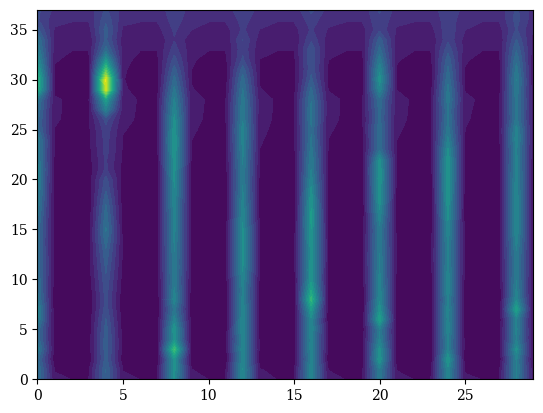

In [14]:
print(data_convert["sw"].shape)

plt.contourf(data_convert["sw"][:30, :, 0].T, levels=20)